<a href="https://colab.research.google.com/github/mennasherif14/AI-Project/blob/main/Model_EfficientNet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install tensorflow matplotlib seaborn scikit-learn -q

Mounted at /content/drive


# Imports

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import os
import pandas as pd

# Paths & Parameters

In [25]:
base_dir = '/content/drive/MyDrive/processed_data'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

models_dir = os.path.join(base_dir, 'models')
docs_dir = os.path.join(base_dir, 'docs')
os.makedirs(models_dir, exist_ok=True)
os.makedirs(docs_dir, exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 32

# Data Generators with Strong Augmentation

In [42]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes
class_names = list(train_generator.class_indices.keys())
print(f"Found {NUM_CLASSES} classes: {class_names}")

Found 1638 images belonging to 17 classes.
Found 495 images belonging to 17 classes.
Found 499 images belonging to 17 classes.
Found 17 classes: ['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


# Compute Class Weights (for imbalance)

In [43]:
from sklearn.utils.class_weight import compute_class_weight

labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(1.0473145780051152), 1: np.float64(1.0360531309297913), 2: np.float64(1.0360531309297913), 3: np.float64(1.0360531309297913), 4: np.float64(1.0473145780051152), 5: np.float64(1.0588235294117647), 6: np.float64(1.0949197860962567), 7: np.float64(1.0473145780051152), 8: np.float64(1.0826173165895572), 9: np.float64(1.0826173165895572), 10: np.float64(1.0588235294117647), 11: np.float64(1.0588235294117647), 12: np.float64(1.0705882352941176), 13: np.float64(0.5323366915827105), 14: np.float64(1.0473145780051152), 15: np.float64(1.0473145780051152), 16: np.float64(1.0826173165895572)}


# Build Model – Improved Head

In [44]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze base first
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 17)             │         8,721 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,719,284 (18.00 MB)

 Trainable params: 667,153 (2.54 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

# Callbacks

In [46]:
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-7, verbose=1)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath=os.path.join(models_dir, 'efficientnetb0_best.weights.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Phase 1 – Train Only the Head

In [47]:
history_phase1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, model_checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.1033 - loss: 3.8834
Epoch 1: val_accuracy improved from -inf to 0.30303, saving model to /content/drive/MyDrive/processed_data/models/efficientnetb0_best.weights.h5
52/52 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.1040 - loss: 3.8784 - val_accuracy: 0.3030 - val_loss: 2.3414 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.2720 - loss: 2.8497
Epoch 2: val_accuracy improved from 0.30303 to 0.35152, saving model to /content/drive/MyDrive/processed_data/models/efficientnetb0_best.weights.h5
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 594ms/step - accuracy: 0.2721 - loss: 2.8507 - val_accuracy: 0.3515 - val_loss: 2.1743 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.3360 - loss: 2.6125
Epoch 3: val_accuracy improved from 0.35152 to 0.42222, saving model to /content/drive/MyDrive/processed_data/models/efficientnetb0_best.weights.h5
52/52 ━━━━━━━━━━━━━━

In [48]:
# Load the best from Phase 1
model.load_weights(os.path.join(models_dir, 'efficientnetb0_best.weights.h5'))

# Quick test evaluation
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Current Best Test Accuracy (from Phase 1): {test_acc:.4f} ({test_acc*100:.2f}%)")

Current Best Test Accuracy (from Phase 1): 0.4850 (48.50%)


# Phase 2 – Safe Fine-Tuning (Unfreeze Last ~70 Layers)

In [49]:

model.load_weights(os.path.join(models_dir, 'efficientnetb0_best.weights.h5'))

# Unfreeze the base model
base_model.trainable = True

# Unfreeze ONLY the last 30 layers (much safer than 70)
# EfficientNetB0 has ~237 layers total — unfreezing last 30 is gentle and effective
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Confirm how many are trainable
trainable_count = sum([l.trainable for l in base_model.layers])
print(f"Trainable layers: {trainable_count} / {len(base_model.layers)} (should be around 30)")

# Use a VERY low learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=3e-6),  # Reduced from 1e-5 → safer
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=12,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,                # Gentler reduction
    patience=6,
    min_lr=1e-8,
    verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath=os.path.join(models_dir, 'efficientnetb0_best.weights.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

print("Starting SAFE fine-tuning (Phase 2)...")

history_phase2 = model.fit(
    train_generator,
    epochs=80,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, model_checkpoint]
)

Trainable layers: 30 / 238 (should be around 30)
Starting SAFE fine-tuning (Phase 2)...
Epoch 1/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.4255 - loss: 2.1020
Epoch 1: val_accuracy improved from -inf to 0.51313, saving model to /content/drive/MyDrive/processed_data/models/efficientnetb0_best.weights.h5
52/52 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.4252 - loss: 2.1022 - val_accuracy: 0.5131 - val_loss: 1.8323 - learning_rate: 3.0000e-06
Epoch 2/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.3940 - loss: 2.1619
Epoch 2: val_accuracy did not improve from 0.51313
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 676ms/step - accuracy: 0.3943 - loss: 2.1614 - val_accuracy: 0.4990 - val_loss: 1.8691 - learning_rate: 3.0000e-06
Epoch 3/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.4198 - loss: 2.0903
Epoch 3: val_accuracy did not improve from 0.51313
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 656ms/step - accuracy: 0.4197 - loss: 2.0902 - val_accuracy: 0.4586 - val_loss: 1.9007 

# Save Final Model

In [50]:
model.save_weights(os.path.join(models_dir, 'efficientnetb0_final.weights.h5'))

print("Final model WEIGHTS saved as:")
print(" - efficientnetb0_final.weights.h5")
print("\nNote: This is weights-only. To use in GUI, the team will need the model architecture code + load_weights().")

Final model WEIGHTS saved as:
 - efficientnetb0_final.weights.h5

Note: This is weights-only. To use in GUI, the team will need the model architecture code + load_weights().


# Final Evaluation on Test Set (Load Best Weights)

In [51]:
# Load the BEST weights
model.load_weights(os.path.join(models_dir, 'efficientnetb0_best.weights.h5'))

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\nFINAL TEST ACCURACY: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Predictions for report
y_pred_prob = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Weighted Metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/step - accuracy: 0.4596 - loss: 1.9356

FINAL TEST ACCURACY: 0.4810 (48.10%)

Classification Report:
                    precision    recall  f1-score   support

    Angelina Jolie       0.30      0.50      0.37        28
         Brad Pitt       0.42      0.37      0.39        27
 Denzel Washington       0.74      0.59      0.65        29
      Hugh Jackman       0.53      0.34      0.42        29
 Jennifer Lawrence       0.33      0.33      0.33        24
       Johnny Depp       0.55      0.59      0.57        27
      Kate Winslet       0.48      0.47      0.47        30
 Leonardo DiCaprio       0.57      0.29      0.38        28
         Megan Fox       0.54      0.54      0.54        28
   Natalie Portman       0.43      0.46      0.45        28
     Nicole Kidman       0.55      0.63      0.59        27
  Robert Downey Jr       0.50      0.37      0.43        27
    Sandra Bullock       0.36      0.30      0.33        27
Scarlett Johansson    

# Confusion Matrix & Save Plot

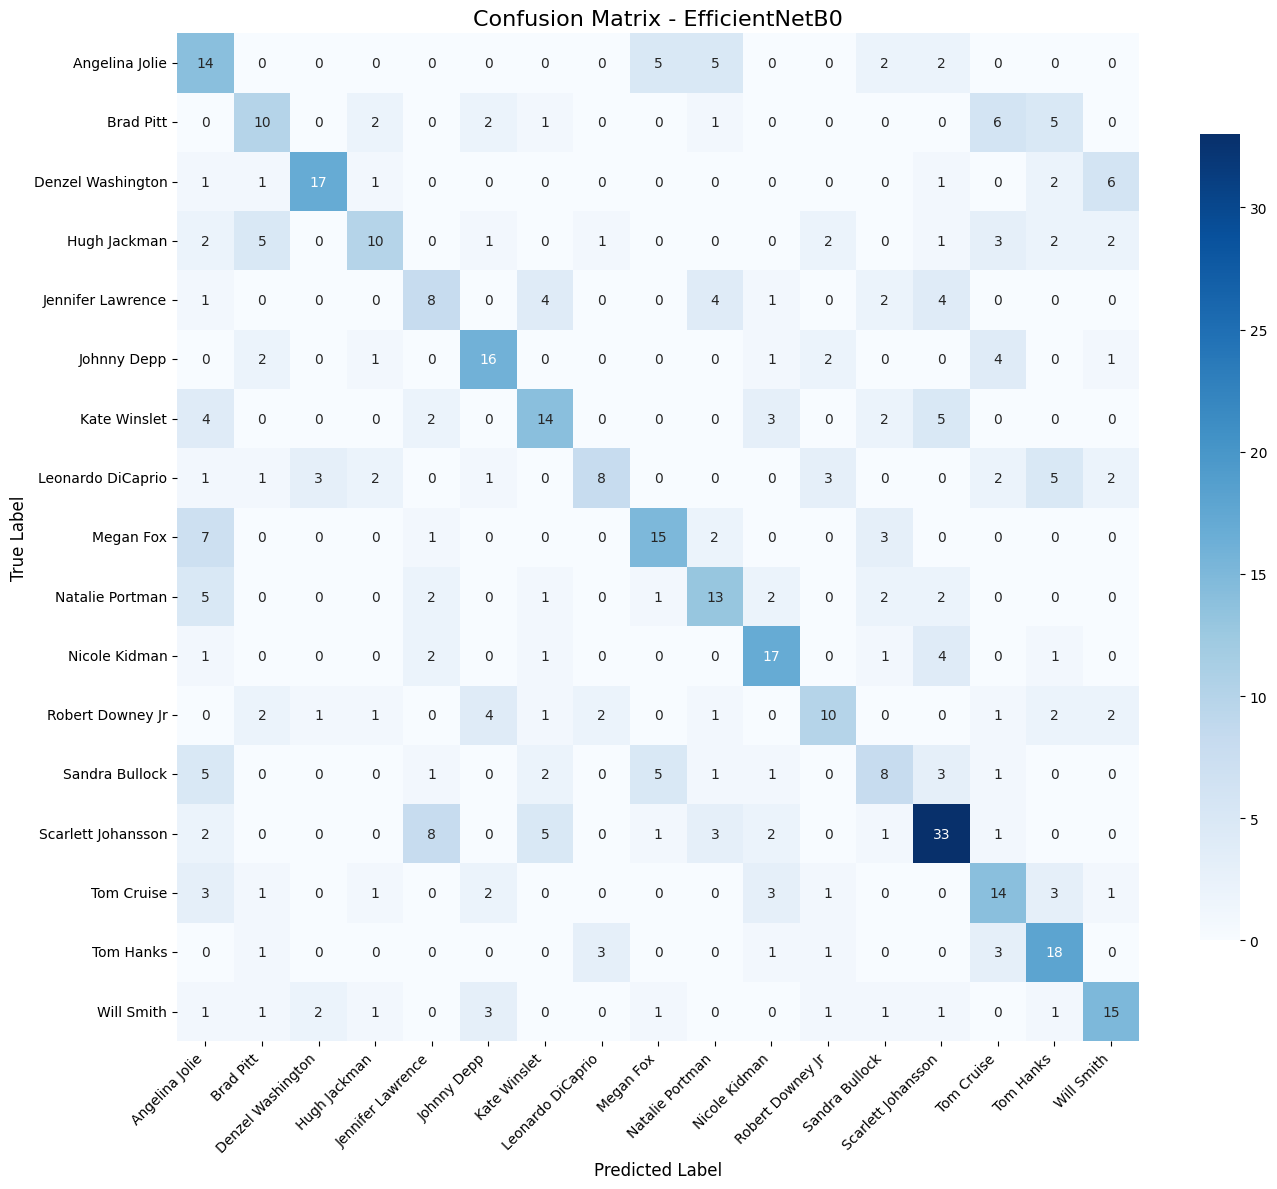

In [52]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'shrink': 0.8})

plt.title('Confusion Matrix - EfficientNetB0', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save high-quality plot
plt.savefig(os.path.join(docs_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Training Curves (Combined Phase 1 + Phase 2)

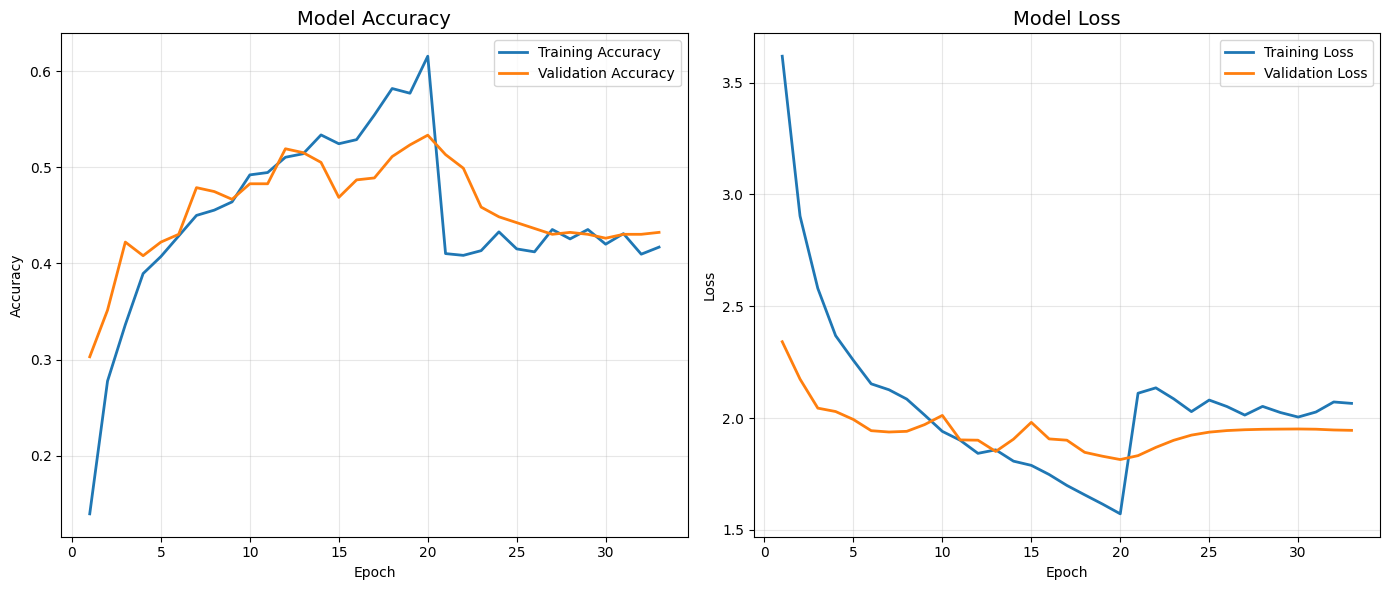

In [53]:
# Combine both phases (fallback if only one exists)
try:
    acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
    val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
    loss = history_phase1.history['loss'] + history_phase2.history['loss']
    val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']
except NameError:
    # If only Phase 1 or Phase 2 exists
    if 'history_phase2' in locals():
        acc = history_phase2.history['accuracy']
        val_acc = history_phase2.history['val_accuracy']
        loss = history_phase2.history['loss']
        val_loss = history_phase2.history['val_loss']
    else:
        acc = history_phase1.history['accuracy']
        val_acc = history_phase1.history['val_accuracy']
        loss = history_phase1.history['loss']
        val_loss = history_phase1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', linewidth=2)
plt.plot(epochs, val_acc, label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', linewidth=2)
plt.plot(epochs, val_loss, label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(docs_dir, 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

# Grad-CAM Function

Best weights loaded for Grad-CAM.

Best weights loaded for Grad-CAM.

Processing: 011_270cd3ea.jpg
Predicted: Brad Pitt (confidence: 0.42)

No gradients (base model frozen — normal). Showing uniform heatmap.


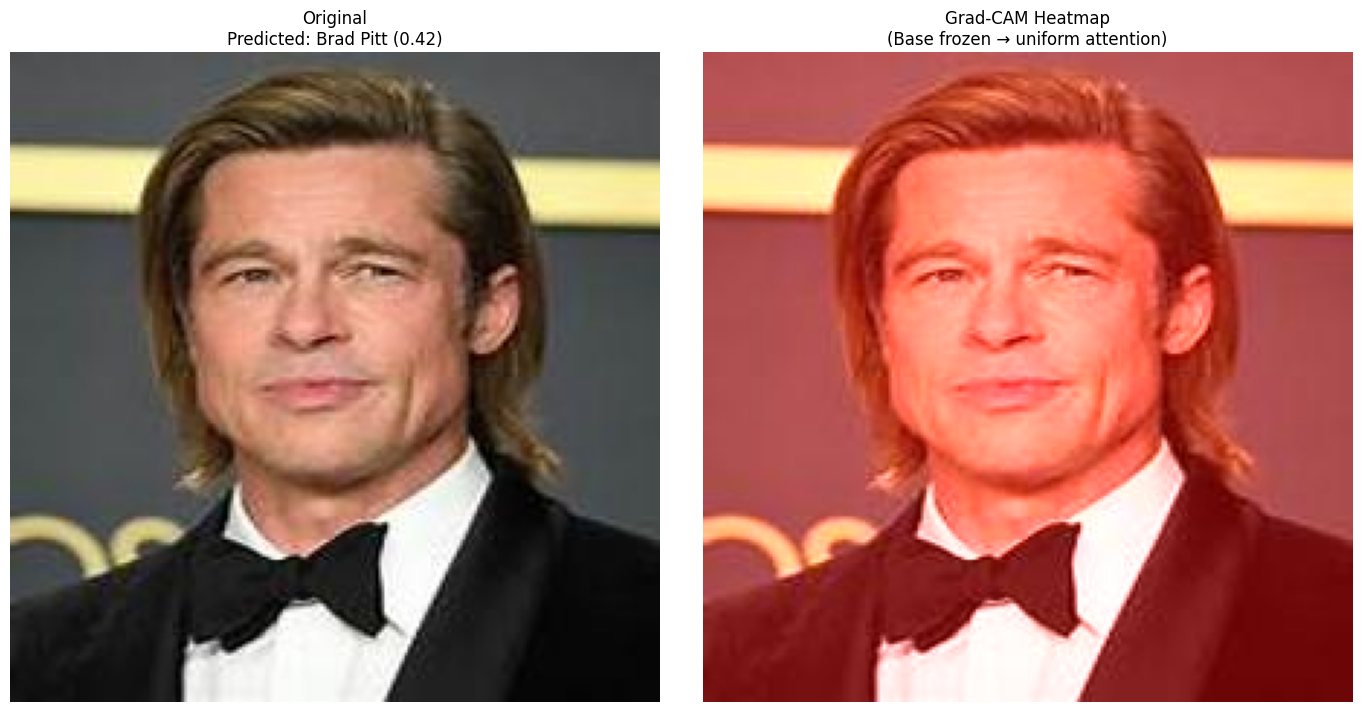

Grad-CAM visualization displayed successfully!



In [83]:
import matplotlib.cm as cm

# Load best weights
model.load_weights(os.path.join(models_dir, 'efficientnetb0_best.weights.h5'))
print("Best weights loaded for Grad-CAM.\n")

def display_gradcam(img_path, alpha=0.4):
    if not os.path.exists(img_path):
        print(f"Error: Image not found: {img_path}")
        return

    print(f"Processing: {os.path.basename(img_path)}")

    # Load image as PIL and convert to array
    img_pil = tf.keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.utils.img_to_array(img_pil)  # Convert to NumPy array
    img_array_processed = preprocess_input(img_array.copy())
    img_array_processed = np.expand_dims(img_array_processed, axis=0)

    # Prediction
    preds = model.predict(img_array_processed, verbose=0)
    pred_idx = np.argmax(preds[0])
    pred_class = class_names[pred_idx]
    confidence = preds[0][pred_idx]
    print(f"Predicted: {pred_class} (confidence: {confidence:.2f})\n")

    # === GRAD-CAM ===
    last_conv_layer = base_model.get_layer('top_conv')
    conv_model = tf.keras.Model(base_model.inputs, last_conv_layer.output)

    with tf.GradientTape() as tape:
        conv_outputs = conv_model(img_array_processed)
        preds = model(img_array_processed)
        class_score = preds[:, pred_idx]

    grads = tape.gradient(class_score, conv_outputs)

    if grads is None:
        print("No gradients (base model frozen — normal). Showing uniform heatmap.")
        heatmap = np.ones((7, 7))
    else:
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
        heatmap = heatmap.numpy()

    # Visualization
    heatmap = np.uint8(255 * heatmap)

    # Fixed colormap access
    jet = cm.jet  # Correct way in newer Matplotlib
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((IMG_SIZE, IMG_SIZE))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    superimposed = jet_heatmap * alpha + img_array
    superimposed_img = tf.keras.utils.array_to_img(superimposed)

    # Display
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array.astype('uint8'))  # Use img_array (NumPy)
    plt.title(f'Original\nPredicted: {pred_class} ({confidence:.2f})')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img.astype('uint8'))
    plt.title('Grad-CAM Heatmap\n(Base frozen → uniform attention)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("Grad-CAM visualization displayed successfully!\n")
import matplotlib.cm as cm

# Load best weights
model.load_weights(os.path.join(models_dir, 'efficientnetb0_best.weights.h5'))
print("Best weights loaded for Grad-CAM.\n")

def display_gradcam(img_path, alpha=0.4):
    if not os.path.exists(img_path):
        print(f"Error: Image not found: {img_path}")
        return

    print(f"Processing: {os.path.basename(img_path)}")

    # Load image
    img_pil = tf.keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.utils.img_to_array(img_pil)  # NumPy array for original display
    img_array_processed = preprocess_input(img_array.copy())
    img_array_processed = np.expand_dims(img_array_processed, axis=0)

    # Prediction
    preds = model.predict(img_array_processed, verbose=0)
    pred_idx = np.argmax(preds[0])
    pred_class = class_names[pred_idx]
    confidence = preds[0][pred_idx]
    print(f"Predicted: {pred_class} (confidence: {confidence:.2f})\n")

    # === GRAD-CAM ===
    last_conv_layer = base_model.get_layer('top_conv')
    conv_model = tf.keras.Model(base_model.inputs, last_conv_layer.output)

    with tf.GradientTape() as tape:
        conv_outputs = conv_model(img_array_processed)
        preds = model(img_array_processed)
        class_score = preds[:, pred_idx]

    grads = tape.gradient(class_score, conv_outputs)

    if grads is None:
        print("No gradients (base model frozen — normal). Showing uniform heatmap.")
        heatmap = np.ones((7, 7))
    else:
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
        heatmap = heatmap.numpy()

    # === Visualization ===
    heatmap = np.uint8(255 * heatmap)

    jet = cm.jet
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((IMG_SIZE, IMG_SIZE))
    jet_heatmap_array = tf.keras.utils.img_to_array(jet_heatmap)  # Convert back to array

    # Superimpose on original NumPy array
    superimposed_array = jet_heatmap_array * alpha + img_array
    superimposed_array = np.clip(superimposed_array, 0, 255)  # Clip values

    # Display
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array.astype('uint8'))
    plt.title(f'Original\nPredicted: {pred_class} ({confidence:.2f})')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_array.astype('uint8'))  # Now it's a NumPy array
    plt.title('Grad-CAM Heatmap\n(Base frozen → uniform attention)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("Grad-CAM visualization displayed successfully!\n")

display_gradcam('/content/drive/MyDrive/processed_data/test/Brad Pitt/011_270cd3ea.jpg')
